In [39]:
from IPython.display import display, Math
from collections import Counter
from collections import OrderedDict

import math
import simpy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Зинин Егор 853502 вариант 8
Рассматривается одноканальная СМО с отказами; на ее вход поступает простейший поток заявок с интенсивностью X. Время обслуживания — показательное с параметром Y = 1 / to6c. Работающий канал может время от времени выходить из строя (отказывать); поток отказов канала — простейший с интенсивностью X. Восстановление (ремонт) вышедшего из строя канала начинается мгновенно после его отказа; время ремонта — показательное с параметром R = 1 / tр . Заявка, которая обслуживалась в момент выхода канала из строя, покидает СМО необслуженной. Найти финальные вероятности состояний СМО: s0 — канал свободен; s1 — канал занят, исправен; s2 — канал ремонтируется и характеристики СМО: относительную и абсолютную пропускную способность системы

In [40]:
def theoretical(l, mu, v, gamma):
    p = []
    p.append((1 + (l / (mu + v)) + (l * v) / (gamma * (mu + v))) ** -1)
    p.append(l / (mu + v) * p[0])
    p.append((v / gamma) * p[1])
    Q = mu * gamma / ( gamma * (mu + v) + l * (gamma + v) )
    A = l * Q
    print("Theoretical")
    display(Math(r'\text{ Финальные вероятности состояний }'))
    display(Math(r's_{0}=\{1+\lambda /(\mu+\nu)+\lambda \nu /[\gamma(\mu+\nu)]\}^{-1}=' + str(p[0])))
    display(Math(r's_{1}=\frac{\lambda}{\mu+\nu} p_{0}=' + str(p[1])))
    display(Math(r's_{2}=\frac{\nu}{\gamma} p_{1}=' + str(p[2])))
    display(Math(r'\text{ Относительная пропускная способность равна }'))
    display(Math(r'Q=\frac{\mu \nu}{\mu \nu+v \nu+\nu \lambda+v \lambda}=' + str(Q)))
    display(Math(r'\text{Абсолютная пропускная способность}'))
    display(Math(r'A=\lambda Q=' + str(A)))
    return p

In [41]:
def empirical(p, until, n_service, len_n):
    A = n_service / until
    Q = n_service / len_n
    print("empirical")
    display(Math(r'\text{ Финальные вероятности состояний }'))
    display(Math(r's_{0}=' + str(p[0])))
    display(Math(r's_{1}=' + str(p[1])))
    display(Math(r's_{2}=' + str(p[2])))
    display(Math(r'\text{ Относительная пропускная способность равна }'))
    display(Math(r'Q=' + str(Q)))
    display(Math(r'\text{Абсолютная пропускная способность}'))
    display(Math(r'A=' + str(A)))

In [42]:
class Queueing(object):
    def __init__(self, env, l, mu, v, gamma):
        self.mu, self.v, self.env = mu, v, env
        self.l, self.gamma = l, gamma
        self.worker = simpy.Resource(env, 1)
        self.worker_busy = []
        self.service = 0

    def service_request(self):
        yield self.env.timeout(np.random.exponential(1 / self.mu))

    def fix_chanel(self):
        yield self.env.timeout(np.random.exponential(1 / self.gamma))


In [43]:
def make_request(env, queueing):
    if queueing.worker.count != 0:
        if "_events" not in queueing.worker.users[0].proc._target.__dict__:
            queueing.worker_busy.append(2)
        else:
            queueing.worker_busy.append(1)
    else:
        queueing.worker_busy.append(queueing.worker.count)
    with queueing.worker.request() as request:
        if len(queueing.worker.queue) == 0:
            refusal = np.random.exponential(1 / queueing.v)
            yield request
            result = yield env.process(queueing.service_request()) | env.timeout(refusal)
            if '_target' not in result.__dict__["events"][0].__dict__:
                yield env.process(queueing.fix_chanel())
            else :
                queueing.service += 1

In [44]:
def run_queuing(env, queueing):
    while True:
        yield env.timeout(np.random.exponential(1 / queueing.l))
        env.process(make_request(env=env, queueing=queueing))

In [45]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [alist[i * length // wanted_parts: (i + 1) * length // wanted_parts]
            for i in range(wanted_parts)]

In [46]:
def show_histogram(values: np.arange, component_name: str, theoretical) -> None:
    sns.set_style("darkgrid")
    plt.figure(dpi=120, figsize=(8, 5))
    plt.bar(list(range(len(values))), values, color=sns.color_palette('deep')[2], linewidth=0)
    plt.title("Histogram of " + component_name )
    plt.xlabel("кол-во времени")
    plt.ylabel("Вероятность")
    plt.hlines(theoretical, 0, 60)
    # sns.histplot(values, palette='deep', color=sns.color_palette('deep')[1], linewidth=2, binwidth=0.4)
    # plt.legend((theoretical + "- theoretical", ''))
    plt.legend([str(theoretical) + " - theoretical", component_name,])
    plt.show()

In [49]:
def main(l, mu, v, until, gamma, plot=False):
    env = simpy.Environment()
    queueing = Queueing(l=l, mu=mu, v=v, gamma=gamma, env=env)
    env.process(run_queuing(env=env, queueing=queueing))
    env.run(until=until)
    p_empirical = list(v / len(queueing.worker_busy) for _, v in
                       dict(OrderedDict(sorted(dict(Counter(queueing.worker_busy)).items()))).items())
    empirical(p=p_empirical, until=until, n_service=queueing.service, len_n = len(queueing.worker_busy))
    p = theoretical(l=l, mu=mu, v=v, gamma=gamma)
    if plot:
        parts = split_list(queueing.worker_busy, wanted_parts=60)
        for i in range(1, len(parts)):
            parts[i].extend(parts[i - 1])
        P = []
        for part in parts:
            P.append(np.array(
                list(v / len(part) for _, v in dict(OrderedDict(sorted(dict(Counter(part)).items()))).items())))
        P = np.array(P).transpose()
        for i in range(3):
            show_histogram(P[i], f"p{i}", p[i])

empirical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Theoretical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

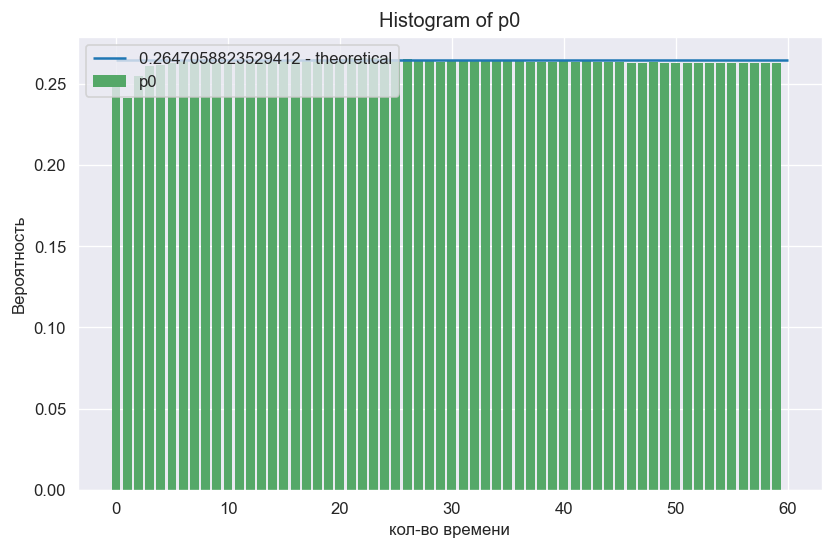

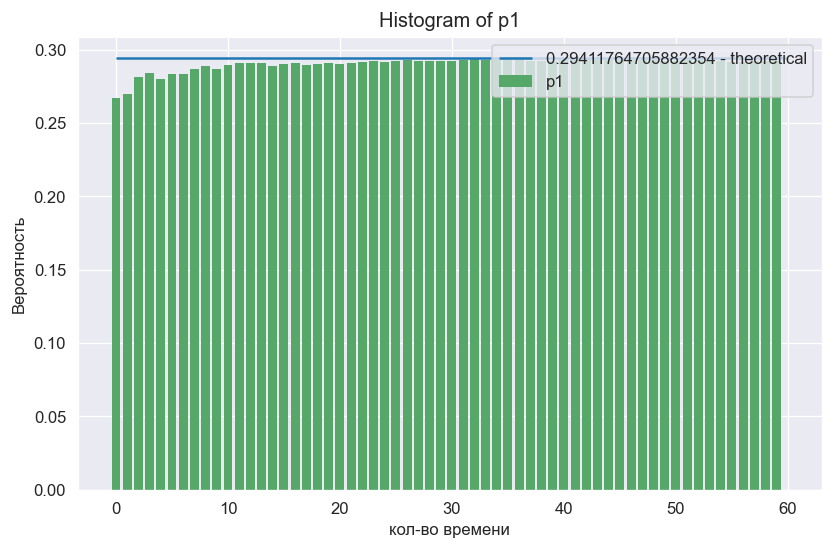

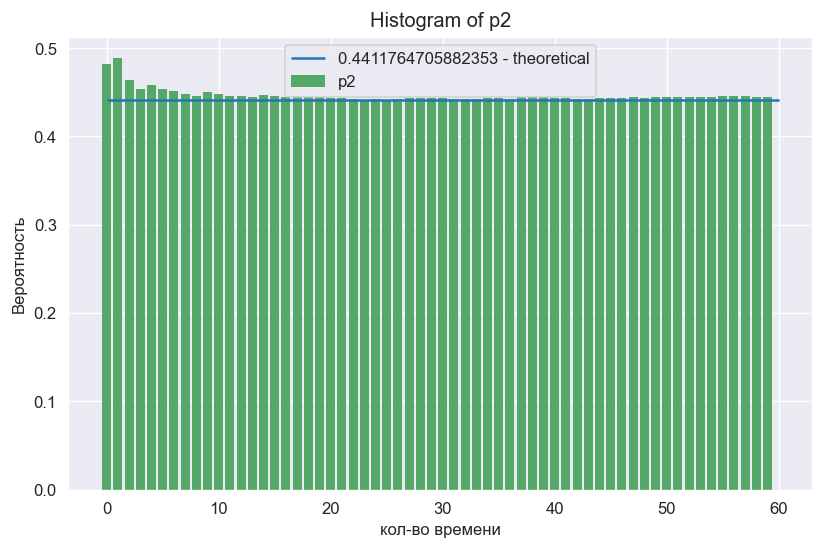

In [50]:
main(l=20, mu=12, v=6, gamma=4, until=10000, plot=True)